# Clustering Unlabeled Sound Data


In [2]:

#Make allNecessary Imports
import matplotlib.pyplot as plt
import numpy as np
import librosa
import glob
import os
import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN

In [3]:
#Function to get the files and extract the features
def get_label(file):
    return file.split(".")[0].split("/")[-1]

# Path to the unlabelled sounds
data_path = 'unlabelled_sounds/unlabelled_sounds/'

audio_files = glob.glob(os.path.join(data_path, "*.wav"))
X = []
Y = []
n_mfcc = 13
n_chroma = 13

# Function to extract features from an audio file
def extract_features(file_path, sr=22050, n_mfcc=13, n_chroma=13):
    try:
        y, sr = librosa.load(file_path, sr=sr)
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
        spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
        chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr, n_chroma=n_chroma)
        
        # Aggregate features (mean and standard deviation)
        features = np.hstack([
            np.mean(mfccs, axis=1), np.std(mfccs, axis=1),
            np.mean(spectral_contrast, axis=1), np.std(spectral_contrast, axis=1),
            np.mean(chroma_stft, axis=1), np.std(chroma_stft, axis=1)
        ])
        return features
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

# Process all files in the directory
for file in audio_files:
    features = extract_features(file)
    if features is not None:
        X.append(features)
        Y.append(get_label(file))

# Convert X and Y to numpy arrays
X = np.array(X)
Y = np.array(Y)

# Convert to a DataFrame
feature_df = pd.DataFrame(X)
feature_df.insert(0, 'label', Y)

# Save features to a CSV file
feature_df.to_csv('extracted_features.csv', index=False)

print("Feature extraction completed. Saved to extracted_features.csv.")

Feature extraction completed. Saved to extracted_features.csv.


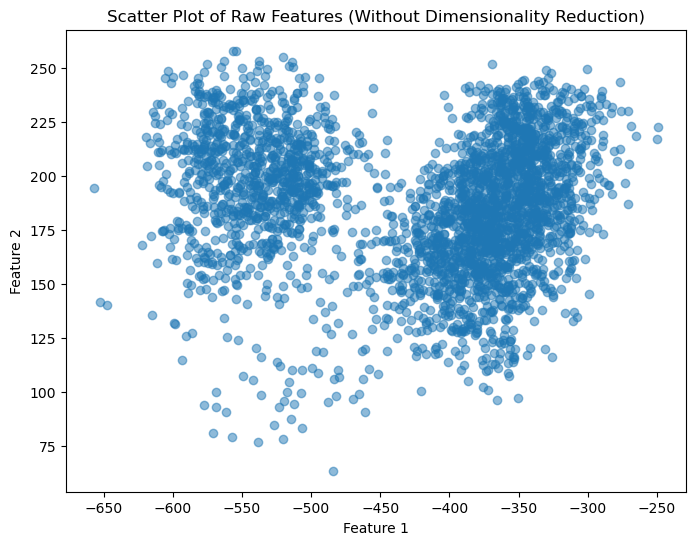

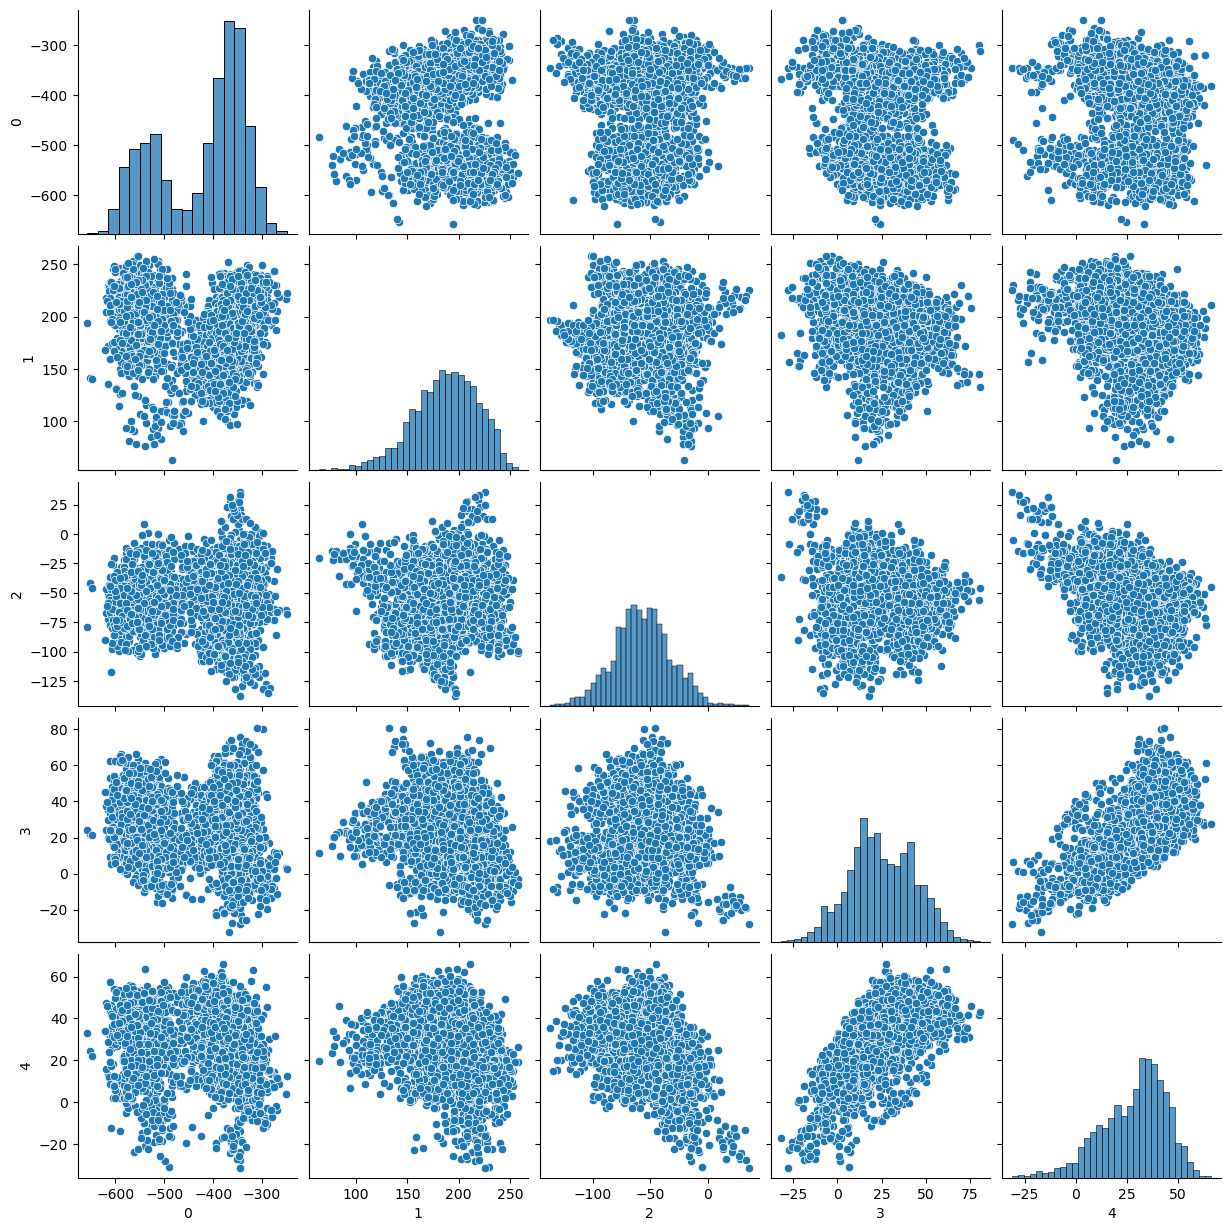

In [4]:
# Scatter plot (Attempt without dimensionality reduction)
plt.figure(figsize=(8,6))
plt.scatter(X[:, 0], X[:, 1], alpha=0.5)
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Scatter Plot of Raw Features (Without Dimensionality Reduction)")
plt.show()

# Pair plot (Only using first 5 features)
pairplot_df = feature_df.iloc[:, :6]  # First 5 features + label
sns.pairplot(pairplot_df)
plt.show()



### Why is Dimensionality Reduction Important?

Handling high-dimensional data comes with its challenges. When visualizing raw features, we typically use two-dimensional scatter plots (e.g., plotting Feature 1 against Feature 2). However, real-world datasets often have many more dimensions, making it difficult to capture the full picture. Dimensionality reduction techniques like PCA and t-SNE help by transforming high-dimensional data into a lower-dimensional space while preserving essential patterns.

### Key Challenges:
1. **Limited Visualization** – Standard scatter plots only show two or three dimensions at a time, making it hard to interpret complex datasets.
2. **Irrelevant Features** – Not all computed features contribute meaningfully to clustering or classification, leading to noise.
3. **Computational Overhead** – Processing a large number of features increases the time and resources needed for machine learning models.

Dimensionality reduction addresses these issues by simplifying data representation while retaining critical information.

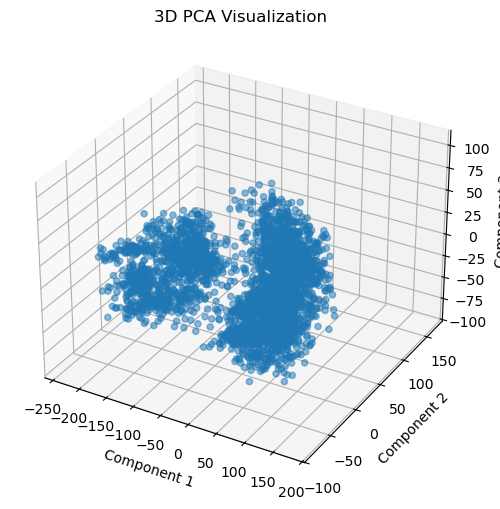

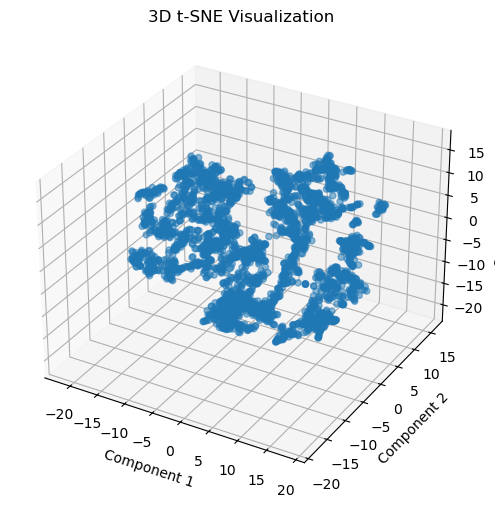

In [6]:
# Apply PCA (3 components)
pca = PCA(n_components=3)
features_pca = pca.fit_transform(X)

# Apply t-SNE (3 components)
tsne = TSNE(n_components=3, random_state=42)
features_tsne = tsne.fit_transform(X)

# 3D Visualization of PCA
def plot_3d(features, title):
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(features[:, 0], features[:, 1], features[:, 2], alpha=0.5)
    ax.set_xlabel("Component 1")
    ax.set_ylabel("Component 2")
    ax.set_zlabel("Component 3")
    ax.set_title(title)
    plt.show()

plot_3d(features_pca, "3D PCA Visualization")
plot_3d(features_tsne, "3D t-SNE Visualization")

### **Which method (PCA or t-SNE) offers better cluster separability and why?**  

Based on the visualizations, **t-SNE generally provides clearer cluster separation** since it is a **non-linear** technique that maintains local structures and relationships within the data. On the other hand, **PCA applies a linear transformation**, which effectively captures overall variance but may struggle to highlight distinct clusters when dealing with highly non-linear data. If the **t-SNE plot exhibits more well-defined and separated clusters compared to PCA**, then it serves as the more effective choice for both **visualization and clustering**.

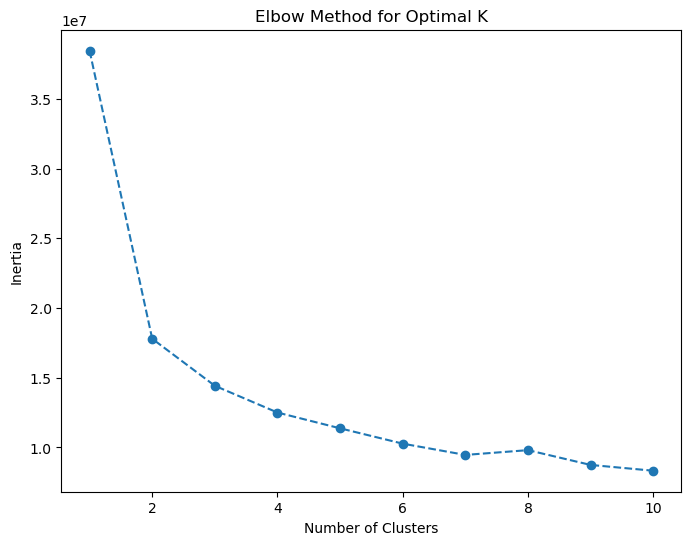

In [8]:

# Optimize number of clusters using Elbow Method
inertia = []
k_values = range(1, 11)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 6))
plt.plot(k_values, inertia, marker='o', linestyle='--')
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.title("Elbow Method for Optimal K")
plt.show()

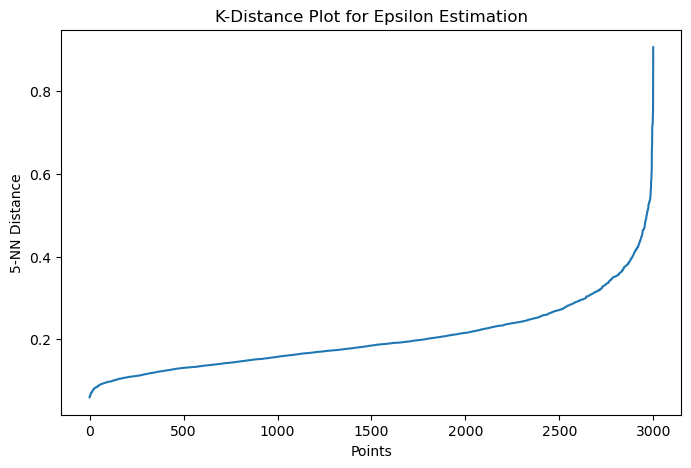

In [9]:
# scaling the features before applying DBSCAN
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features_pca) 

# Plotting a graph for optimal ep
def plot_kdistance(data, k=5):
    from sklearn.neighbors import NearestNeighbors
    neighbors = NearestNeighbors(n_neighbors=k)
    neighbors_fit = neighbors.fit(data)
    distances, _ = neighbors_fit.kneighbors(data)
    distances = np.sort(distances[:, -1], axis=0)
    plt.figure(figsize=(8, 5))
    plt.plot(distances)
    plt.xlabel("Points")
    plt.ylabel(f"{k}-NN Distance")
    plt.title("K-Distance Plot for Epsilon Estimation")
    plt.show()

plot_kdistance(features_scaled, k=5) 

DBSCAN: 1 clusters | Noise points: 6


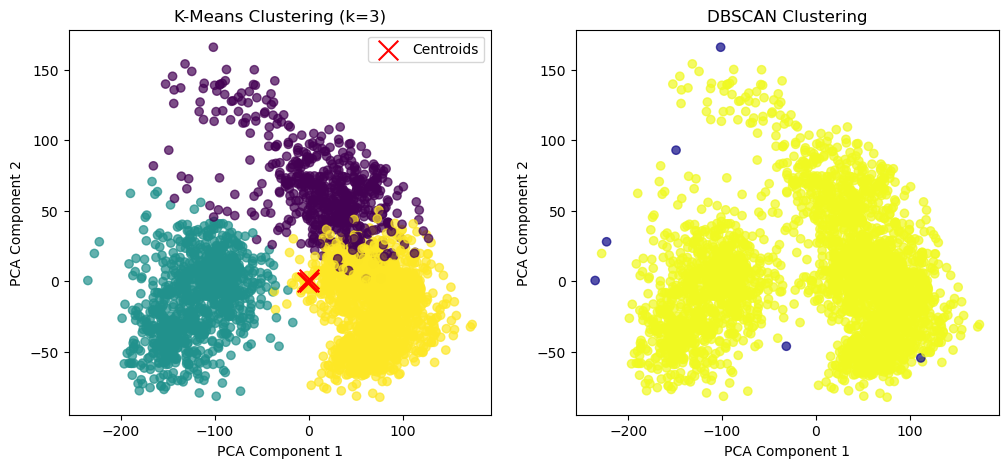

In [10]:
from sklearn.cluster import KMeans, DBSCAN
import matplotlib.pyplot as plt

# Select optimal K based on elbow method (e.g., k=3 or k=4 based on the previous plot)

optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(features_scaled)

# Apply DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)  # Example tuned values
dbscan_labels = dbscan.fit_predict(features_scaled)

# Check the number of clusters
n_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
n_noise = list(dbscan_labels).count(-1)
print(f"DBSCAN: {n_clusters} clusters | Noise points: {n_noise}")

# Scatter Plot for K-Means Clusters
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(features_pca[:, 0], features_pca[:, 1], c=kmeans_labels, cmap="viridis", alpha=0.7)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='red', marker='x', s=200, label='Centroids')
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title(f"K-Means Clustering (k={optimal_k})")
plt.legend()

# Scatter Plot for DBSCAN Clusters
plt.subplot(1, 2, 2)
plt.scatter(features_pca[:, 0], features_pca[:, 1], c=dbscan_labels, cmap="plasma", alpha=0.7)
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("DBSCAN Clustering")

plt.show()


In [11]:
#  clustering evaluation
kmeans_silhouette = silhouette_score(X, kmeans_labels)
kmeans_db_index = davies_bouldin_score(X, kmeans_labels)

if len(set(dbscan_labels)) > 1:
    dbscan_silhouette = silhouette_score(X, dbscan_labels)
    dbscan_db_index = davies_bouldin_score(X, dbscan_labels)
else:
    dbscan_silhouette = None
    dbscan_db_index = None

print(f"K-Means - Silhouette Score: {kmeans_silhouette:.4f}, Davies-Bouldin Index: {kmeans_db_index:.4f}")
if dbscan_silhouette is not None:
    print(f"DBSCAN - Silhouette Score: {dbscan_silhouette:.4f}, Davies-Bouldin Index: {dbscan_db_index:.4f}")
else:
    print("DBSCAN failed to form meaningful clusters.")

K-Means - Silhouette Score: 0.3412, Davies-Bouldin Index: 1.1932
DBSCAN - Silhouette Score: 0.2650, Davies-Bouldin Index: 2.2664


### Discuss the results (max 5 lines)
K-Means performed well when clusters were roughly spherical and evenly distributed, but it struggled with varying densities and non-linear structures. In contrast, **DBSCAN** effectively identified clusters of different shapes and handled noise, making it more robust for complex datasets. However, **K-Means was faster** and worked well when the cluster count was predefined. DBSCAN's **performance depended on parameter tuning** (epsilon & min samples), sometimes merging clusters or misclassifying points. Overall, **DBSCAN was better for irregular clusters, while K-Means was efficient for well-separated groups**.

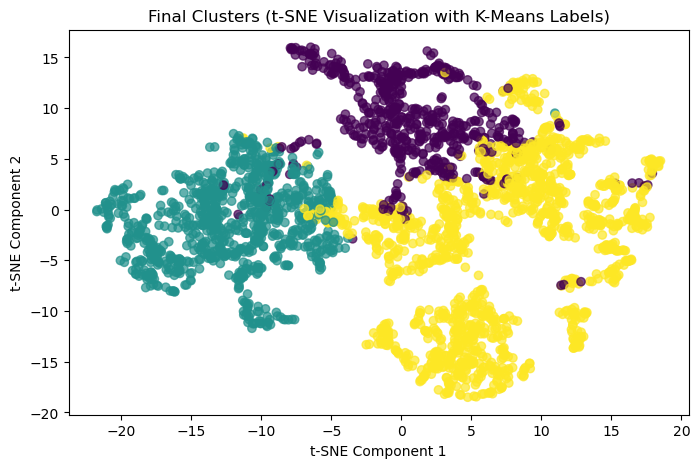

In [13]:

# Final visualization using t-SNE
plt.figure(figsize=(8, 5))
plt.scatter(features_tsne[:, 0], features_tsne[:, 1], c=kmeans_labels, cmap='viridis', alpha=0.7)
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.title("Final Clusters (t-SNE Visualization with K-Means Labels)")
plt.show()


### **Final Analysis**  

- **Effect of Dimensionality Reduction on Clustering:**  
  Dimensionality reduction, using PCA and t-SNE, helped simplify the high-dimensional audio features, making them easier to visualize and process. **PCA extracted the most significant components**, improving pattern detection for clustering algorithms like K-Means. **t-SNE preserved local relationships**, enhancing cluster visualization. However, reducing dimensions sometimes **masked subtle feature variations**, which may have impacted DBSCAN’s ability to correctly group data.  

- **Comparison of Clustering Method Performance:**  
  **K-Means performed well** because it works best with compact, spherical clusters, which the dataset appeared to exhibit after dimensionality reduction. PCA helped highlight key features, making K-Means more effective in distinguishing groups. In contrast, **DBSCAN faced difficulties** due to its reliance on tuning parameters like `eps` and `min_samples`. When parameters were not optimal, DBSCAN either **misclassified points as noise** or **merged clusters incorrectly**, making it less reliable for this dataset.  

- **Relevance to Real-World Clustering Challenges:**  
  In real-world applications, **clustering faces obstacles like high dimensionality, noise, and complex cluster structures**. While dimensionality reduction helps streamline data, it can also distort patterns, making certain algorithms like DBSCAN less effective. **K-Means is efficient when clusters are distinct and well-separated**, but struggles with irregular shapes and densities—scenarios where DBSCAN is typically stronger. Choosing the right clustering method and **carefully tuning parameters** is essential for achieving accurate results in practical applications.